Установка зависимостей

In [ ]:
!pip uninstall tensorflow

In [ ]:
!pip install tensorflow

In [ ]:
!pip install keras

Проверка версии tensorflow

In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.8.0


Загрузка датасета

In [ ]:
from google.colab import drive

mount_path = '/content/drive'
drive.mount(mount_path)
mount_path += '/MyDrive/NN/flowers/'

Mounted at /content/drive


Вывод категорий цветов

In [ ]:
import os
flower_types = os.listdir(mount_path)
print(flower_types)

['tulip', 'dandelion', 'daisy', 'sunflower', 'rose']


In [ ]:
import cv2                  
from tqdm import tqdm
from random import shuffle  
from zipfile import ZipFile
from PIL import Image

Создаем массив изображений (X) и массив меток (Z), устанавкиваем размер изображения (150 x 150)

In [ ]:
X=[]
Z=[]
IMG_SIZE=150

Функция чтения фото цветов с диска и заполнение массивов изображений и меток

In [ ]:
def make_train_data(flower_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR) # чтение в RGB -> тензор (высота x ширина x 3, где 3 — это байты, по одному байту на каждую из компонент)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        
        X.append(np.array(img))
        Z.append(str(flower_type))

Проходимся циклом по всем папкам с фото цветов, заполняем массивы

In [ ]:
for flower_type in flower_types:
  make_train_data(flower_type.capitalize(), mount_path + flower_type)
print(len(X))

100%|██████████| 784/784 [00:16<00:00, 48.03it/s] 

4317


Выводим случайные изображения с метками

In [ ]:
import random as rn

In [ ]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Flower: '+Z[l])
        
plt.tight_layout()

Вывод одного изображения с цветовой шкалой

In [ ]:
plt.figure()
plt.imshow(X[1000])
plt.colorbar()
plt.grid(False)
plt.show()


Кодируем категории цветов (ромашка -> 0, роза -> 1 и т.п.) и масштабируем значения пикселей в диапазон от 0 до 1, прежде чем передавать их в модель нейронной сети (для этого делим значения на 255)

In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

In [ ]:
le=LabelEncoder()
Y=le.fit_transform(Z)
Y=to_categorical(Y,5)
X=np.array(X)
X=X/255

Чтобы убедиться, что данные имеют правильный формат, отображаем рандомные 8 изображений из обучающего набора и отображаем имя класса под каждым изображением.

In [ ]:
fig,ax=plt.subplots(2,4)
fig.set_size_inches(15,15)
for i in range(2):
    for j in range (4):
        l=rn.randint(0,len(Y))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title(f'Flower: {Z[l]} | {Y[l]}')
        
plt.tight_layout()

Создаем сеть

In [ ]:
# model = tf.keras.Sequential([
#     tf.keras.layers.Flatten(input_shape=(IMG_SIZE, IMG_SIZE, 3)),
#     tf.keras.layers.Dense(128, activation='relu'), # полносвязный слой с 128 выходными нейронами и функцией активации max(x, 0)
#     tf.keras.layers.Dense(5),
#     tf.keras.Sequential([model, tf.keras.layers.Softmax()]) # добавили слой потерь
# ])
# Первый вариант
# model = tf.keras.Sequential([
#     tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
#     tf.keras.layers.MaxPooling2D((2,2)),
#     tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'),
#     tf.keras.layers.MaxPooling2D((2,2)),
#     tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.Dense(5),
#     tf.keras.layers.Softmax() # добавили слой потерь
# ])

# Второй вариант
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(112, (3,3), activation = 'relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(56, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(28, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(14, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(5),
    tf.keras.layers.Softmax() # добавили слой потерь
])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 148, 148, 112)     3136      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 74, 74, 112)      0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 72, 72, 56)        56504     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 36, 36, 56)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 34, 34, 28)        14140     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 17, 17, 28)      

Компилируем сеть (оптимизатор - Adam, функция потерь - Категориальная перекрестная энтропия, метрики - точность)

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Разделяем набор данных на тренировочный и тестовый (25% от общего набора)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=42)

In [ ]:
print(x_train.shape)
print(y_train.shape)

Обчаем сеть

In [ ]:
x_train_train,x_tain_val,y_train_train,y_train_val=train_test_split(x_train,y_train,test_size=0.25,random_state=42)

In [ ]:
print(x_train_train.shape)
print(y_train_train.shape)

(2427, 150, 150, 3)
(2427, 5)


In [ ]:
print(x_tain_val.shape)
print(y_train_val.shape)

In [ ]:
History = model.fit(x_train_train, y_train_train, epochs=40, validation_data=(x_tain_val, y_train_val))

Epoch 1/40
76/76 [==============================] - 10s 120ms/step - loss: 1.4557 - accuracy: 0.3247 - val_loss: 1.3314 - val_accuracy: 0.3790
Epoch 2/40
76/76 [==============================] - 8s 105ms/step - loss: 1.1902 - accuracy: 0.4825 - val_loss: 1.1411 - val_accuracy: 0.5247
Epoch 3/40
76/76 [==============================] - 8s 106ms/step - loss: 1.1052 - accuracy: 0.5315 - val_loss: 1.0676 - val_accuracy: 0.5481
Epoch 4/40
76/76 [==============================] - 8s 106ms/step - loss: 1.0270 - accuracy: 0.5880 - val_loss: 0.9932 - val_accuracy: 0.6086
Epoch 5/40
76/76 [==============================] - 8s 107ms/step - loss: 0.9578 - accuracy: 0.6292 - val_loss: 1.1319 - val_accuracy: 0.5123
Epoch 6/40
76/76 [==============================] - 8s 106ms/step - loss: 0.9410 - accuracy: 0.6432 - val_loss: 0.9618 - val_accuracy: 0.6185
Epoch 7/40
76/76 [==============================] - 8s 110ms/step - loss: 0.8855 - accuracy: 0.6560 - val_loss: 0.9072 - val_accuracy: 0.6580
Epoch

Выводим информацию о сети

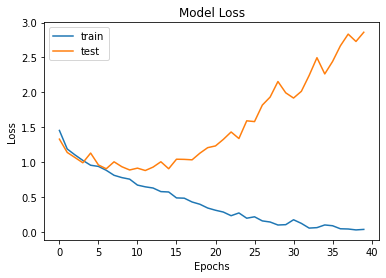

In [ ]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

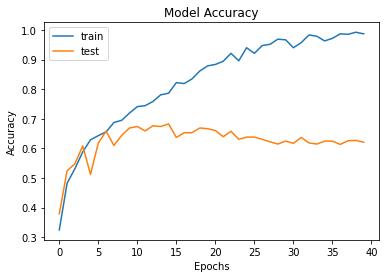

In [ ]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

34/34 - 2s - loss: 3.0199 - accuracy: 0.6056 - 2s/epoch - 51ms/step


Используем сеть для классификации тестового набора

In [ ]:
predictions = model.predict(x_test)

Берем максимум в каждой строке 

In [ ]:
pred_digits=np.argmax(predictions,axis=1)

Сверяем предсказания с реальными категориями

In [ ]:
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test)):
    if(np.argmax(y_test[i])==pred_digits[i]):
        prop_class.append(i)
    # if(len(prop_class)==8):
    #     break

i=0
for i in range(len(y_test)):
    if(not np.argmax(y_test[i])==pred_digits[i]):
        mis_class.append(i)
    # if(len(mis_class)==8):
    #     break

In [ ]:
print(x_test.shape)

(1080, 150, 150, 3)


In [ ]:
print(f'Количество верных предсказаний - {len(prop_class)} ({len(prop_class) * 100 / x_test.shape[0]:0.3f}%)')
print(f'Количество ошибочных предсказаний - {len(mis_class)} ({len(mis_class) * 100 / x_test.shape[0]:0.3f}%)')

Количество верных предсказаний - 654 (60.556%)
Количество ошибочных предсказаний - 426 (39.444%)


Выводим фото, у которых правильно определилась категория

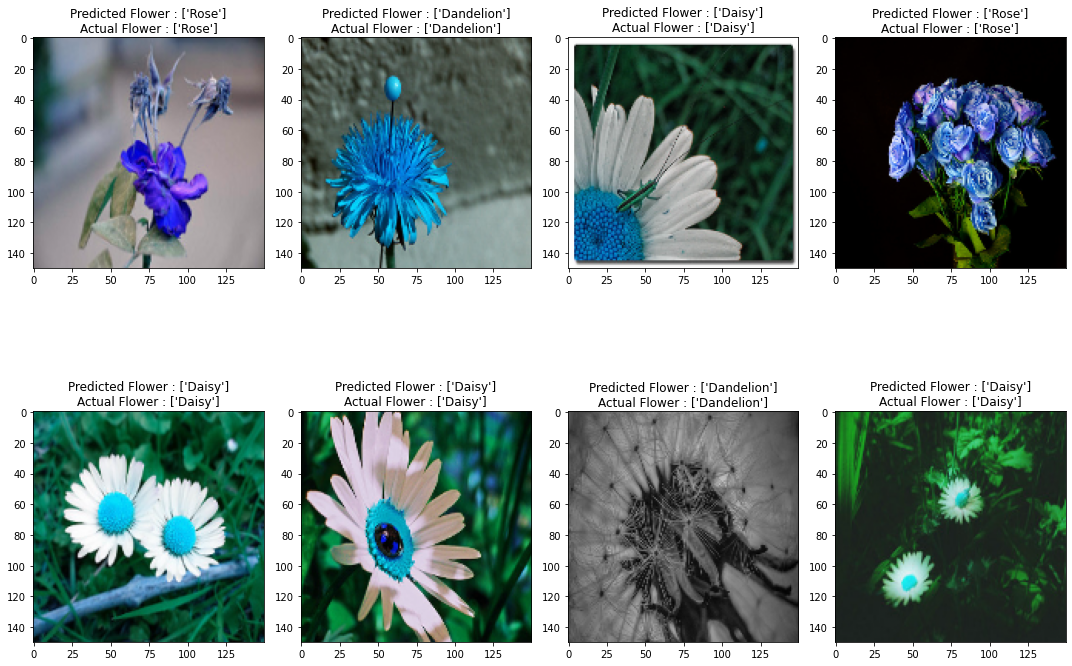

In [ ]:
count=0
fig,ax=plt.subplots(2,4)
fig.set_size_inches(15,15)
for i in range (2):
    for j in range (4):
        ax[i,j].imshow(x_test[prop_class[count]])
        s1 = str(le.inverse_transform([pred_digits[prop_class[count]]]))
        s2 = str(le.inverse_transform([np.argmax([y_test[prop_class[count]]])]))
        ax[i,j].set_title("Predicted Flower : "+ s1 +"\n"+"Actual Flower : "+ s2)
        plt.tight_layout()
        count+=1

Выводим фото, у которых неправильно определилась категория

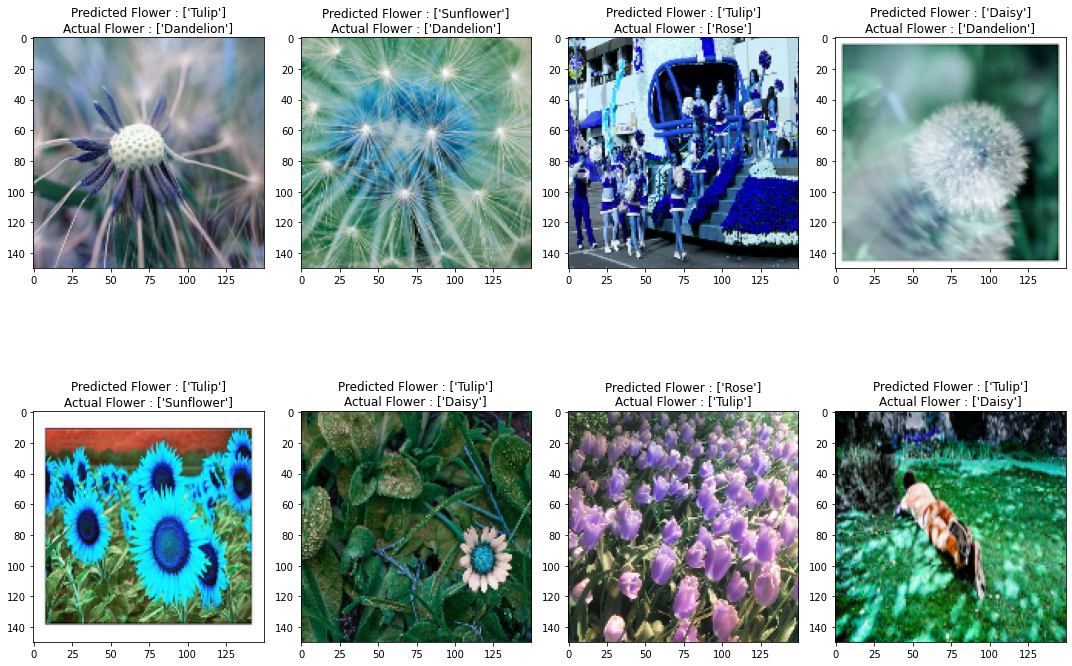

In [ ]:
count=0
fig,ax=plt.subplots(2,4)
fig.set_size_inches(15,15)
for i in range (2):
    for j in range (4):
        ax[i,j].imshow(x_test[mis_class[count]])
        s1 = str(le.inverse_transform([pred_digits[mis_class[count]]]))+"\n"+"Actual Flower : "
        ax[i,j].set_title("Predicted Flower : "+s1+str(le.inverse_transform([np.argmax([y_test[mis_class[count]]])])))
        plt.tight_layout()
        count+=1

Декодируем ранее закодированные категирии цветов

In [ ]:
transformed_labels = [str(i).lower() for i in le.inverse_transform(range(5))]

Функции для вывода фото с графиком принадлежности к какой-либо категории

In [ ]:
from operator import index
def plot_image(i, predictions_array, true_label, img):
  img = img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = str(le.inverse_transform([pred_digits[i]])[0])
  true_label = str(le.inverse_transform([np.argmax(true_label[i])])[0])

  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                100*np.max(predictions_array),
                                true_label),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predicted_label = str(le.inverse_transform([pred_digits[i]])[0])
  true_label = str(le.inverse_transform([np.argmax(true_label[i])])[0])

  thisplot = plt.bar(transformed_labels, predictions_array, color="#775777")
  thisplot[transformed_labels.index(predicted_label.lower())].set_color('red')
  thisplot[transformed_labels.index(true_label.lower())].set_color('blue')


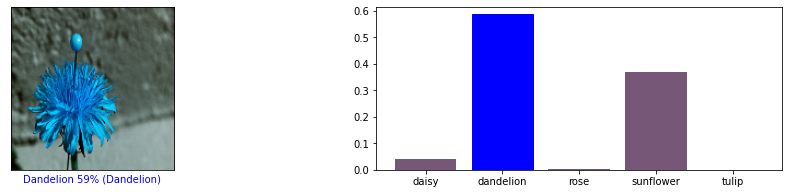

In [ ]:
i = 1
plt.figure(figsize=(16,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], y_test, x_test)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  y_test)
plt.show()


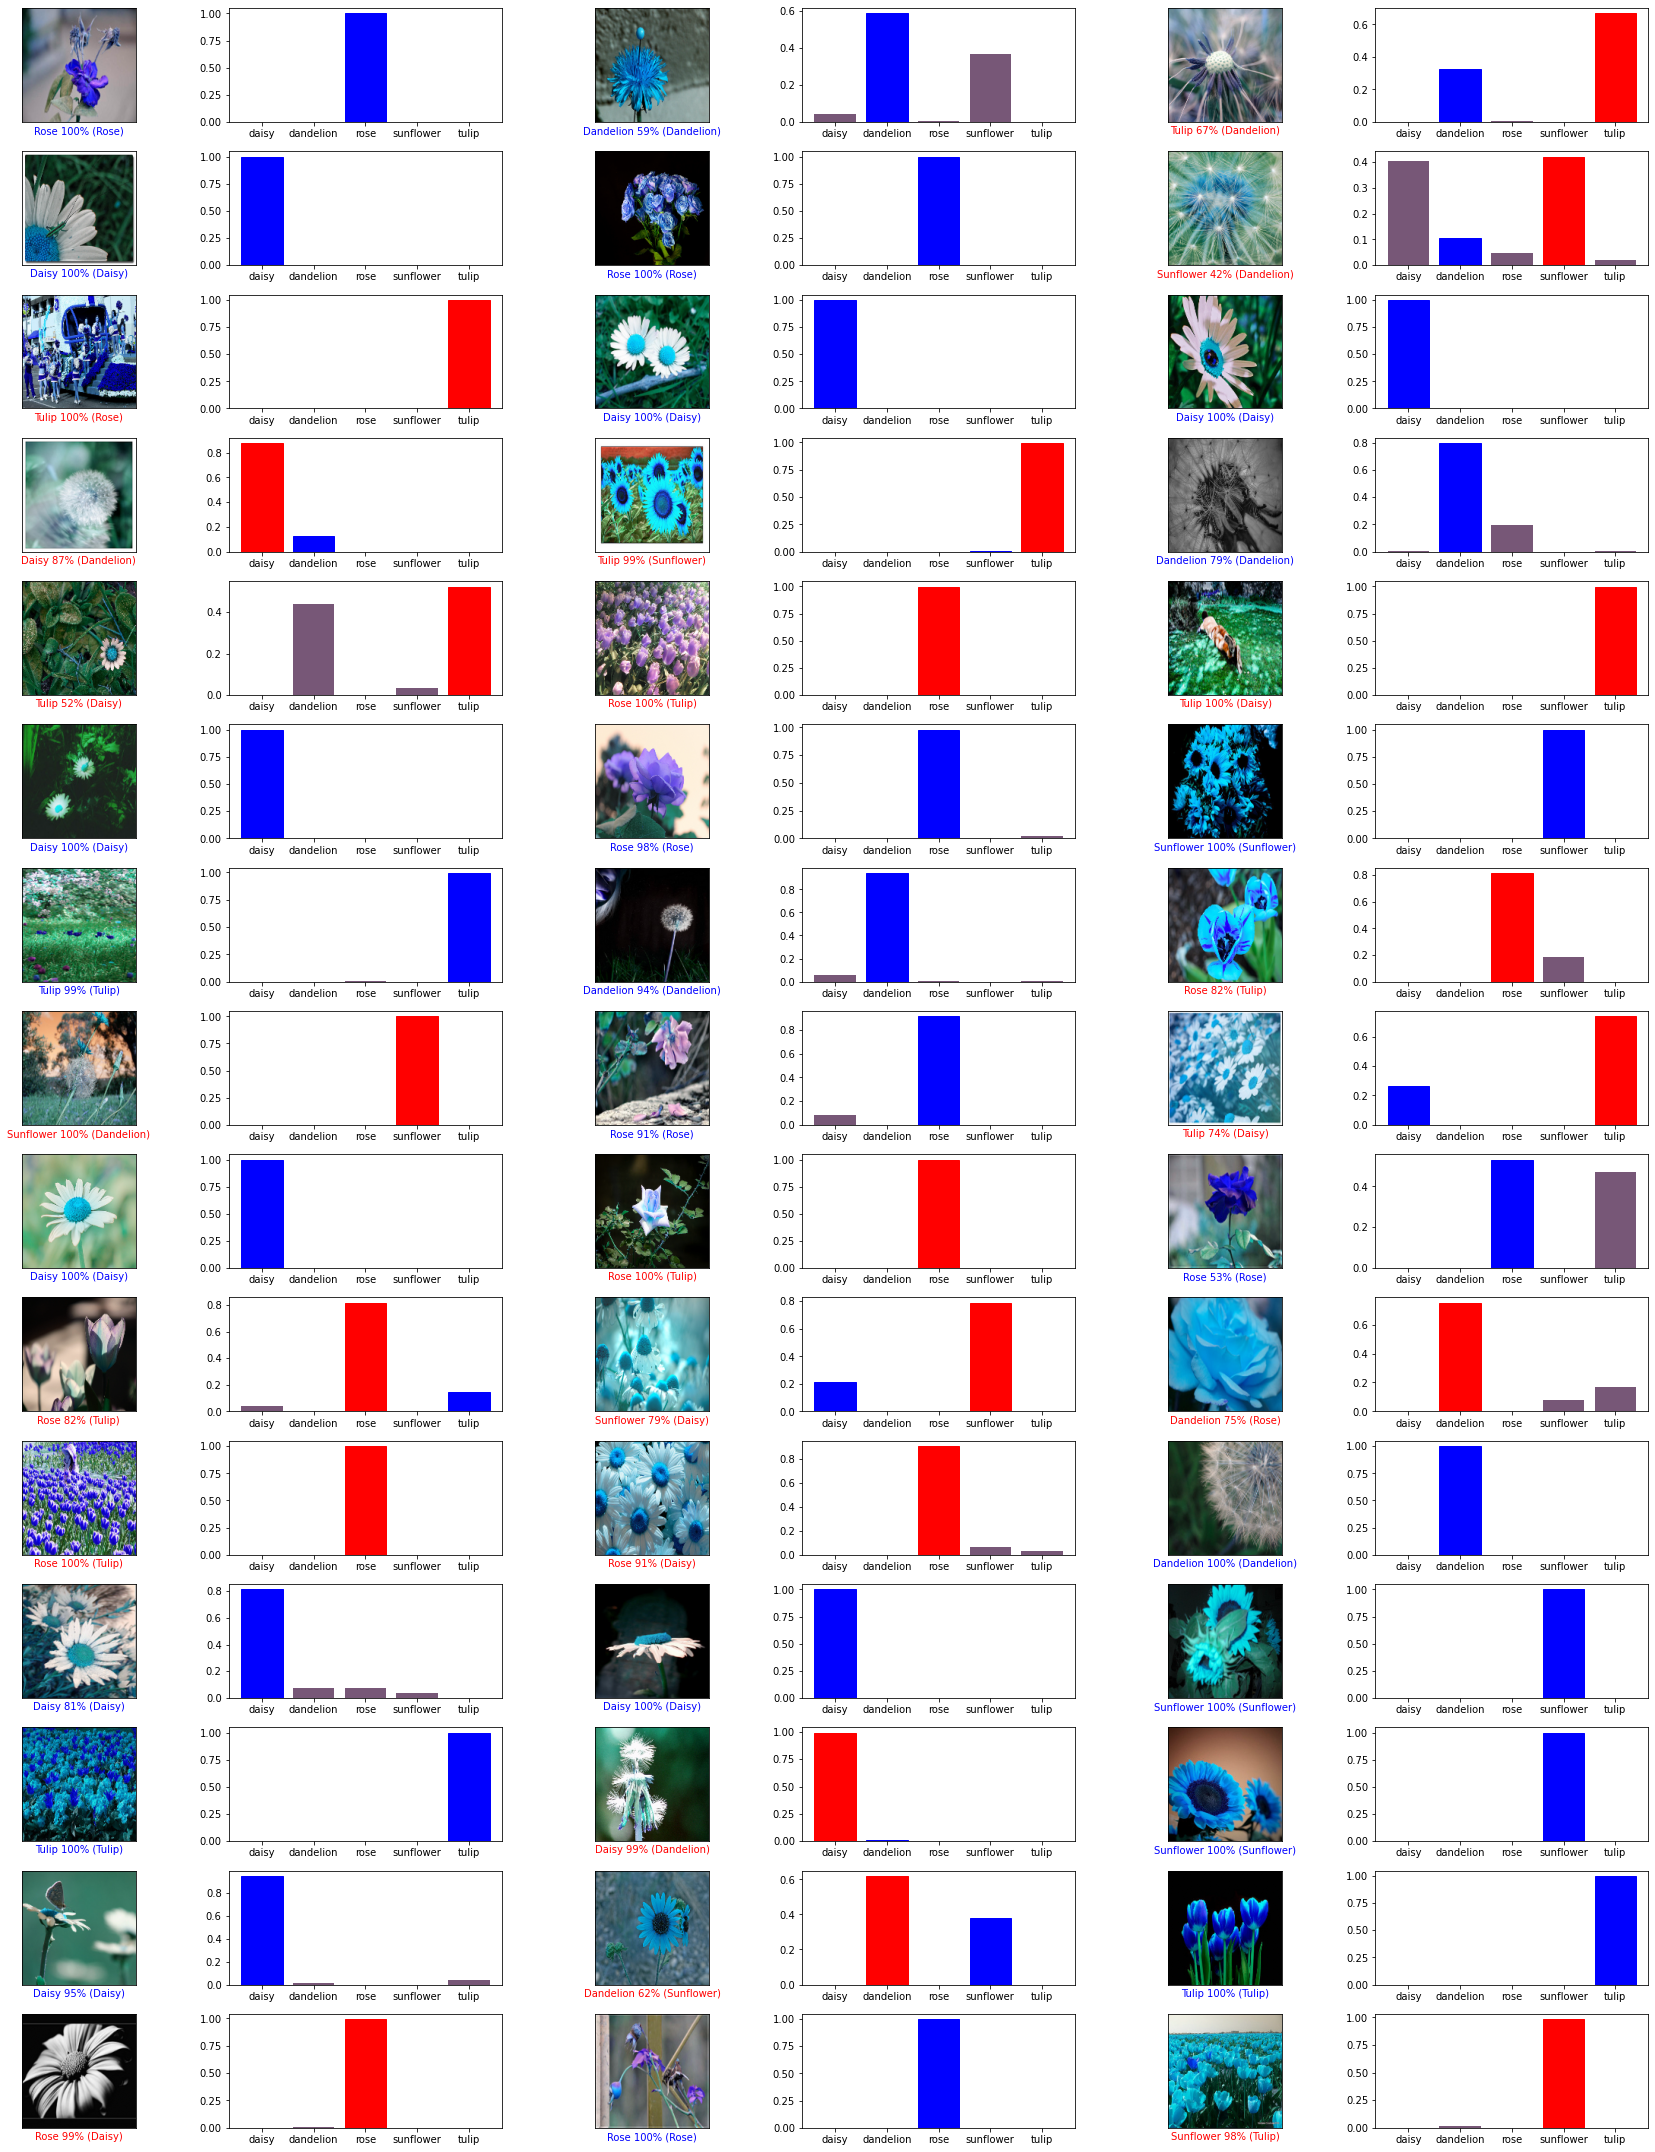

In [ ]:
num_rows = 15
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], y_test, x_test)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], y_test)
plt.tight_layout()
plt.show()
